# AI prep workbook

## Reading in Parquet and CSV files

In [ ]:
import os
import pandas as pd
from scripts.csvtoparquet import csv_to_parquet_single_file

# Example usage
current_directory = os.getcwd()
csv_file_path = os.path.join(current_directory, 'input', 'train_labels.csv')
output_file_path = os.path.join(current_directory, 'input', 'full_labels.parquet')

chunksize = 100000  
sample_rows = 50000


csv_to_parquet_single_file(csv_file_path, output_file_path, chunksize=chunksize, sample_rows=sample_rows)



In [ ]:
import os
import pandas as pd
from scripts.parquetreader import read_parquet_file 


# Example usage
current_directory = os.getcwd()

training = os.path.join(current_directory, 'input', 'full_data.parquet')
labels = os.path.join(current_directory, 'input', 'full_labels.parquet')

dftrain=read_parquet_file(training)
dflabels=read_parquet_file(labels)



In [ ]:
result_df = pd.merge(dftrain, dflabels[['customer_ID', 'target']], on='customer_ID', how='inner')
df_dropped = result_df.drop(columns=['D_134','D_135', 'D_136', 'D_137','D_138','D_142'])
df_dropped.drop_duplicates()
df_dropped.fillna(0)
print(df_dropped.shape[0])

current_directory = os.getcwd()
output_file_sampledparquet = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')
df_dropped.to_parquet(output_file_sampledparquet)


# Upload parquet to Blob Storage

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient,ContainerClient 
import os
from dotenv import load_dotenv
load_dotenv()
connection_str = os.getenv('connection_str')


# Azure storage account detail
container_name = 'trainingdata'

# File to upload
current_directory = os.getcwd()
parquet_file_path = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')

# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string(connection_str)

# Create the container client
container_client = blob_service_client.get_container_client(container_name)

# Create a blob client using the local file name as the name for the blob
blob_client = blob_service_client.get_blob_client(container=container_name, blob=os.path.basename(parquet_file_path))

print(f"Uploading to Azure Storage as blob:\n\t {os.path.basename(parquet_file_path)}")

# Upload the created file
with open(parquet_file_path, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("Upload completed successfully")


# Reading Parquet File

In [ ]:
import pandas as pd
from azure.storage.blob import BlobServiceClient
from io import BytesIO
from dotenv import load_dotenv
load_dotenv()
connection_str = os.getenv('connection_str')

# Initialize a BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connection_str)

# Specify your container and the name for the file in the container
container_name = 'trainingdata'
blob_name = 'new_train_data.parquet'

def read_parquet_file_from_blob(connection_str, container_name, blob_name):

    blob_service_client = BlobServiceClient.from_connection_string(connection_str)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    
    stream = BytesIO()
    blob_client.download_blob().download_to_stream(stream)
    stream.seek(0)  # Go to the start of the stream
    df = pd.read_parquet(stream)
    
    return df



In [ ]:
import pandas as pd
import os

current_directory = os.getcwd()
parquet_file_path = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')


# Read the Parquet file
dfmodelstep1 = pd.read_parquet(parquet_file_path)

# Now you can work with your DataFrame 'df'
print(dfmodelstep1.shape[0])

## Train/Testsplit

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into features and target
# Replace 'target_column_name' with the name of your target column
X = dfmodelstep1.drop(columns=['target', 'customer_ID'])
y = dfmodelstep1['target']

# Split the data into training and test sets
# test_size=0.2 means 20% of the data will be used for the test set, and 80% for the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Epoch 1/10


/Users/danramirez/mbs-transformers/new_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5215 - loss: 0.8122 - val_accuracy: 0.6500 - val_loss: 0.6440
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.6014 - loss: 0.6826 - val_accuracy: 0.7200 - val_loss: 0.5788
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.6332 - loss: 0.6140 - val_accuracy: 0.7550 - val_loss: 0.5291
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7032 - loss: 0.5617 - val_accuracy: 0.7750 - val_loss: 0.4878
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7195 - loss: 0.5460 - val_accuracy: 0.8100 - val_loss: 0.4573
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7768 - loss: 0.5064 - val_accuracy: 0.8050 - val_loss: 0.4261
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8105 - loss: 0.4620 - val_accuracy: 0.8000 - val_loss: 0.4045
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.4780 - val_accuracy: 0.8200 - val_loss: 

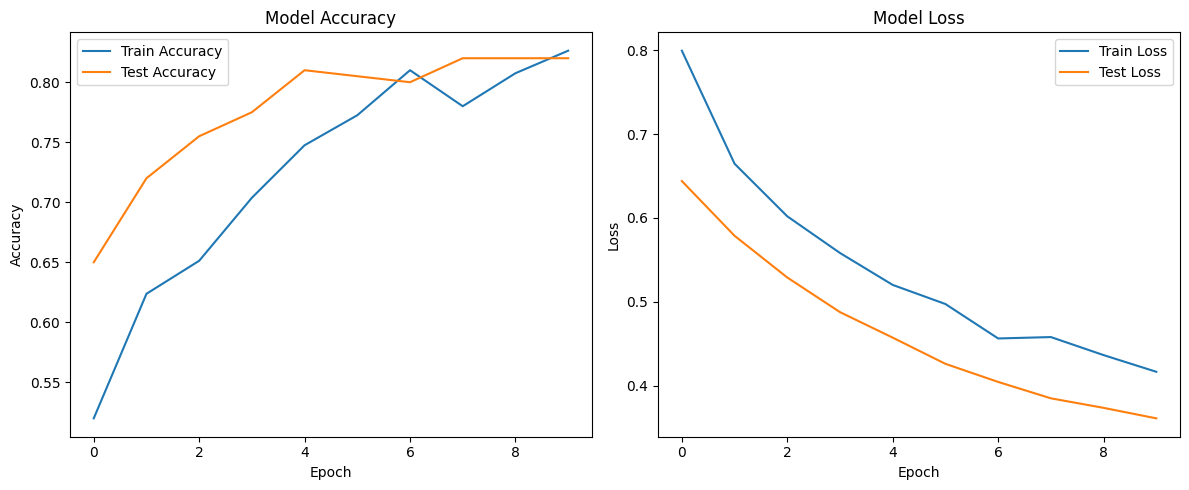

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Example dataset generation (replace with your actual data)
# Let's create a synthetic dataset for demonstration purposes
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Visualization of training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
